In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy
import pickle
import pefile
import sklearn.ensemble as ek
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from tqdm import tqdm

In [2]:
# Input Dataset 

DM = pd.read_csv("C:\\Data Raihan\\Penelitian Threshold\\Dataset\\CIC-DDoS2019-Portmap\\Portmap.csv") #DM--> Dataset Malware

C:\Users\Muhammad Raihan\AppData\Local\Temp\ipykernel_15052\2314360681.py:3: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  DM = pd.read_csv("C:\\Data Raihan\\Penelitian Threshold\\Dataset\\CIC-DDoS2019-Portmap\\Portmap.csv") #DM--> Dataset Malware


In [3]:
DM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191694 entries, 0 to 191693
Data columns (total 88 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    191694 non-null  int64  
 1   Flow ID                       191694 non-null  object 
 2    Source IP                    191694 non-null  object 
 3    Source Port                  191694 non-null  int64  
 4    Destination IP               191694 non-null  object 
 5    Destination Port             191694 non-null  int64  
 6    Protocol                     191694 non-null  int64  
 7    Timestamp                    191694 non-null  object 
 8    Flow Duration                191694 non-null  int64  
 9    Total Fwd Packets            191694 non-null  int64  
 10   Total Backward Packets       191694 non-null  int64  
 11  Total Length of Fwd Packets   191694 non-null  float64
 12   Total Length of Bwd Packets  191694 non-nul

In [4]:
#Feature Selection
X = DM.drop(['Unnamed: 0','Flow ID',' Source IP', ' Destination IP', ' Timestamp', 'SimillarHTTP', 'Flow Bytes/s', ' Flow Packets/s', ' Label'],axis=1).values    #Droping this because classification model will not accept object type elements (float and int only)
# Target variable
y = DM[' Label'].values

In [5]:
# Replace inf and -inf with NaN
X = np.where(np.isinf(X), np.nan, X)

# Convert X to a DataFrame if it isn't one already, remove NaN rows, and keep the corresponding indices in y
X = pd.DataFrame(X).dropna()
y = y[X.index]

In [6]:
#Data Fitting and choosing the important variables
extratrees = ek.ExtraTreesClassifier().fit(X,y)
model = SelectFromModel(extratrees, prefit=True)
X_new = model.transform(X)
nbfeatures = X_new.shape[1]

In [7]:
features = []
index = numpy.argsort(extratrees.feature_importances_)[::-1][:nbfeatures]

In [8]:
#All the required features
X_columns = DM.drop(['Unnamed: 0','Flow ID',' Source IP', ' Destination IP', ' Timestamp', 'SimillarHTTP', 'Flow Bytes/s', ' Flow Packets/s', ' Label'], axis=1).columns
features = []
for f in range(nbfeatures):
    print("%d. feature %s (%f)" % (f + 1, X_columns[index[f]], extratrees.feature_importances_[index[f]]))
    features.append(X_columns[index[f]])

1. feature  Inbound (0.156411)
2. feature  Source Port (0.097852)
3. feature  URG Flag Count (0.093981)
4. feature  Fwd Packet Length Min (0.078916)
5. feature  Protocol (0.071141)
6. feature  Min Packet Length (0.048813)
7. feature  Down/Up Ratio (0.048067)
8. feature  Average Packet Size (0.033722)
9. feature  CWE Flag Count (0.026049)
10. feature  Bwd Packet Length Min (0.022004)
11. feature  Fwd Packet Length Mean (0.021900)
12. feature  ACK Flag Count (0.021012)
13. feature  Avg Fwd Segment Size (0.019176)
14. feature  Max Packet Length (0.017398)
15. feature  RST Flag Count (0.016325)
16. feature  Packet Length Mean (0.016125)
17. feature  Destination Port (0.014480)
18. feature Fwd PSH Flags (0.014393)
19. feature  Packet Length Std (0.013997)
20. feature  Fwd Packet Length Max (0.013819)
21. feature Bwd Packet Length Max (0.013171)
22. feature  Bwd Packet Length Mean (0.012721)


In [9]:
# Memilih 1% data dari setiap fitur/column
sample_size = int(0.01 * len(DM))
sampled_data = DM.groupby(' Label').apply(lambda x: x.iloc[:sample_size]).reset_index(drop=True)

In [10]:
# Mencoba mencari threshold terbaik pada fitur yang dipilih
hasil_threshold = []

def Thresholding(threshold, feature):
    # Melakukan thresholding
    BenignDataThreshold = sampled_data[sampled_data[feature] > int(threshold)]
    MalwareDataThreshold = sampled_data[sampled_data[feature] <= int(threshold)]

    # menentukan TP, TN, FP, FN
    from sklearn.metrics import confusion_matrix

    # Untuk BenignDataThreshold
    y_true_benign = ["BENIGN"] * len(BenignDataThreshold)
    y_pred_benign = BenignDataThreshold[" Label"]

    # Untuk MalwareDataThreshold
    y_true_malware = ["Portmap"] * len(MalwareDataThreshold)
    y_pred_malware = MalwareDataThreshold[" Label"]

    # Menyatukan true labels dan predicted labels
    y_true = y_true_benign + y_true_malware
    y_pred = y_pred_benign.tolist() + y_pred_malware.tolist()

    # Menghitung confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Menghitung Precision, Recall, F1-score, dan Accuracy
    PrecisionThreshold = tp/(tp+fp) if (tp+fp) != 0 else 0
    RecallThreshold = tp/(tp+fn) if (tp+fn) != 0 else 0
    F1ScoreThreshold = 2 * ((PrecisionThreshold*RecallThreshold)/(PrecisionThreshold+RecallThreshold)) if (PrecisionThreshold+RecallThreshold) != 0 else 0
    AccuracyThreshold = (tp+tn)/(tp+fp+tn+fn) if (tp+fp+tn+fn) != 0 else 0

    matrix = [[feature, threshold], [PrecisionThreshold], [RecallThreshold], [F1ScoreThreshold], [AccuracyThreshold]]
    hasil_threshold.append(matrix)

for feature in tqdm(features, desc='Progress'):
    Max = sampled_data[feature].max()
    Min = sampled_data[feature].min()

    for x in range(int(Min), int(Max + 1)):
        Thresholding(x, feature)

print(hasil_threshold)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 22/22 [27:20<00:00, 74.57s/it]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




In [11]:
winner = [['', 0], [0], [0], [0], [0]]  # Format: [[feature, threshold], [precision], [recall], [f1-score], [accuracy]]

for result in hasil_threshold:
    if result[4][0] > winner[4][0]:
        winner = result

print(f"Dengan fitur {winner[0][0]} dan threshold {winner[0][1]}, menghasilkan akurasi {winner[4][0]} yang menjadikan angka threshold tersebut adalah threshold terbaik yang dapat digunakan.")


Dengan fitur  Packet Length Std dan threshold 3, menghasilkan akurasi 0.8447286012526096 yang menjadikan angka threshold tersebut adalah threshold terbaik yang dapat digunakan.


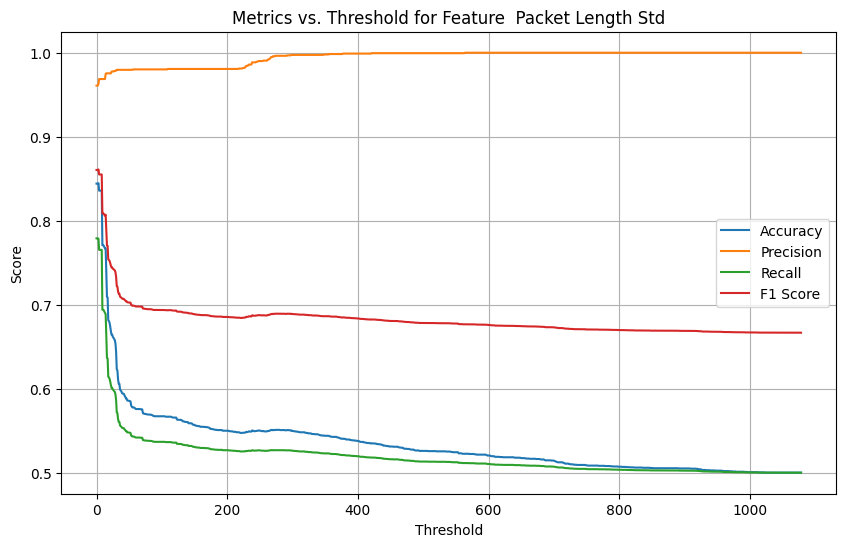

In [12]:
# Mendapatkan fitur pemenang dan thresholdnya
winner_feature, winner_threshold = winner[0]

# Memfilter hasil threshold untuk fitur pemenang
winner_results = [result for result in hasil_threshold if result[0][0] == winner_feature]

# Pisahkan hasil menjadi list berdasarkan feature dan kolom
thresholds, precision, recall, f1_score, accuracy = [], [], [], [], []
for result in winner_results:
    thresholds.append(result[0][1])
    precision.append(result[1][0])
    recall.append(result[2][0])
    f1_score.append(result[3][0])
    accuracy.append(result[4][0])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy, label='Accuracy')
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, f1_score, label='F1 Score')

plt.title(f'Metrics vs. Threshold for Feature {winner_feature}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()
